### Testing cloud cover detection @ CUES

Here I am trying to determine when we have clouds over thes CUES site by comparing an estimated clear-sky downward longwave radiation (LWd) against observed ("all sky") LWd.

We expect observed LWd to be greater than estimated clear-sky LWd when we have cloud-cover. This should be especially useful for identifying cloud-cover during nighttime when we don't have shortwave solar radiation to also check if we have sunny or cloudy skies. 

This method is similar to the Clear-Sky Index of Marty & Philipona (2000) but has two main differences:
1. They used an empirical clear-sky emissivity method based on Brutsaert (1975); I've used the ensemble mean of 17 different clear-sky downward longwave methods.
2. They computed $CSI = \frac{\epsilon_{obs}}{\epsilon_{cs}}$; I've computed  $CSI = \frac{LWd_{obs}}{LWd_{cs} + \alpha}$ where $\alpha$ is some threshold value that I fit to a set of observations.


| **CSI**      | **Sky**     |
| :------------- | -----------: |
|  $\leq 1$ | clear-sky, no clouds    |
| $\gt 1$  | cloudy sky, overcast |


But where do we draw the line t0 classify between cloud and not cloudy? We'd expect there to be some gradient of values around a CSI value of 1 that represent varying degrees of partial-cloud. We could either see if we should use a CSI other than 1 to draw the line between clear-sky and cloudy (changing the slope away from 1), and we can adjust the threshold ($\alpha$, in units $W m^{-2}$) (shifting the line along the x-axis).

We can do a "brute force" test across the range of values we'd expect to be valid. A confusion matrix is computed for each test to measure the performance of a specific parameter choice. We can compute a confusion matrix because we have some time periods with cloud cover observations (We have cloud cover observations in the daytime, when a solar pyranometer could detect changes in downward shortwave radiation). I'm using the f1-score from the confusion matrix to find the "best" parameter values.

We can also take a qualitative look at the GOES-16 ABI IR observations from the same time, where we expect to see cold cloud-tops when they pass over the site, and see how well our cloud detection method matches the satellite observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Import the cloud_detect functions:

In [3]:
import cloud_detect

Define functions we'll use

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
---

#### Try to find the best threshold to distinguish clear-sky from cloudy:

Load observations from CUES site:

In [5]:
cues_dataset = pd.read_pickle('data/CUES_L1_Temp_Rad_Snowdepth_2017-2020.pkl').to_xarray()
# Select only before October 2019 where we have the CUES sun flag
cues_ds = cues_dataset.where(cues_dataset.datetime < np.datetime64('2019-10-01'))

Set up input variables from CUES observations.

In [6]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
Ta = T + 273.15 # temperature [K]
LWd_obs = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
sun_flag_obs = cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']
elev = 2940 # meters

Try to brute force the optimum threshold for identifying cloud-cover:

In [12]:
# Set up the LWd threshold parameter space we want to search for a high f1-score
lw_threshold_min = -40
lw_threshold_max = 40
lw_n_steps = 80 # number of steps to take in between threshold_min and threshold_max

# Set up the CSI threshold parameter space we want to search for a high f1-score
csi_threshold_min = -0.2
csi_threshold_max = 0.2
csi_n_steps = 10 # number of steps to take in between threshold_min and threshold_max

# Choose the fraction of the entire data set to test each time (chooses the size of the random sample)
random_sample_fraction = 0.001

# Create a dataframe to hold the results:
d = {'lw_threshold': [], 'csi_threshold': [], 'f1_score': [], 'precision': [], 'recall': []}
df = pd.DataFrame(data=d)

# Search the 1-D parameter space wtihin the bounds we specified
for repeats in range(3): # repeat it more than once if we want
    for lw_threshold in np.linspace(lw_threshold_min,lw_threshold_max,lw_n_steps):
        for csi_threshold in np.linspace(csi_threshold_min,csi_threshold_max,csi_n_steps):
            print("Testing lw_threshold: {}, csi_threshold: {}".format(lw_threshold, csi_threshold))
            # Generate a random boolean array to select approximately some % of the original data for testing
            random_numbers = np.random.rand(len(Ta))
            random_bools = random_numbers < random_sample_fraction 
    
            # Select this random subset from the input data
            Tair_sample = Ta[random_bools]
            RH_sample = RH[random_bools]
            LWd_obs_sample = LWd_obs[random_bools]
            sun_flag_obs_sample = sun_flag_obs[random_bools]
    
            _, _, precision, recall, f1_score = cloud_detect.lw_cloud_detect(Tair_sample, RH_sample, LWd_obs_sample, sun_flag_obs_sample, elev, lw_threshold, csi_threshold)
            new_row = {'lw_threshold': lw_threshold, 'csi_threshold': csi_threshold, 'f1_score': f1_score, 'precision': precision, 'recall': recall}
            df = df.append(new_row, ignore_index=True)


Testing lw_threshold: -40.0, csi_threshold: -0.2
Testing lw_threshold: -40.0, csi_threshold: -0.15555555555555556
Testing lw_threshold: -40.0, csi_threshold: -0.11111111111111112
Testing lw_threshold: -40.0, csi_threshold: -0.06666666666666668
Testing lw_threshold: -40.0, csi_threshold: -0.022222222222222227
Testing lw_threshold: -40.0, csi_threshold: 0.022222222222222227
Testing lw_threshold: -40.0, csi_threshold: 0.06666666666666665
Testing lw_threshold: -40.0, csi_threshold: 0.1111111111111111
Testing lw_threshold: -40.0, csi_threshold: 0.15555555555555556
Testing lw_threshold: -40.0, csi_threshold: 0.2
Testing lw_threshold: -38.9873417721519, csi_threshold: -0.2
Testing lw_threshold: -38.9873417721519, csi_threshold: -0.15555555555555556
Testing lw_threshold: -38.9873417721519, csi_threshold: -0.11111111111111112
Testing lw_threshold: -38.9873417721519, csi_threshold: -0.06666666666666668
Testing lw_threshold: -38.9873417721519, csi_threshold: -0.022222222222222227
Testing lw_thres

Testing lw_threshold: -28.860759493670884, csi_threshold: -0.11111111111111112
Testing lw_threshold: -28.860759493670884, csi_threshold: -0.06666666666666668
Testing lw_threshold: -28.860759493670884, csi_threshold: -0.022222222222222227
Testing lw_threshold: -28.860759493670884, csi_threshold: 0.022222222222222227
Testing lw_threshold: -28.860759493670884, csi_threshold: 0.06666666666666665
Testing lw_threshold: -28.860759493670884, csi_threshold: 0.1111111111111111
Testing lw_threshold: -28.860759493670884, csi_threshold: 0.15555555555555556
Testing lw_threshold: -28.860759493670884, csi_threshold: 0.2
Testing lw_threshold: -27.848101265822784, csi_threshold: -0.2
Testing lw_threshold: -27.848101265822784, csi_threshold: -0.15555555555555556
Testing lw_threshold: -27.848101265822784, csi_threshold: -0.11111111111111112
Testing lw_threshold: -27.848101265822784, csi_threshold: -0.06666666666666668
Testing lw_threshold: -27.848101265822784, csi_threshold: -0.022222222222222227
Testing 

Testing lw_threshold: -17.72151898734177, csi_threshold: -0.11111111111111112
Testing lw_threshold: -17.72151898734177, csi_threshold: -0.06666666666666668
Testing lw_threshold: -17.72151898734177, csi_threshold: -0.022222222222222227
Testing lw_threshold: -17.72151898734177, csi_threshold: 0.022222222222222227
Testing lw_threshold: -17.72151898734177, csi_threshold: 0.06666666666666665
Testing lw_threshold: -17.72151898734177, csi_threshold: 0.1111111111111111
Testing lw_threshold: -17.72151898734177, csi_threshold: 0.15555555555555556
Testing lw_threshold: -17.72151898734177, csi_threshold: 0.2
Testing lw_threshold: -16.708860759493668, csi_threshold: -0.2
Testing lw_threshold: -16.708860759493668, csi_threshold: -0.15555555555555556
Testing lw_threshold: -16.708860759493668, csi_threshold: -0.11111111111111112
Testing lw_threshold: -16.708860759493668, csi_threshold: -0.06666666666666668
Testing lw_threshold: -16.708860759493668, csi_threshold: -0.022222222222222227
Testing lw_thres

Testing lw_threshold: -6.582278481012658, csi_threshold: -0.11111111111111112
Testing lw_threshold: -6.582278481012658, csi_threshold: -0.06666666666666668
Testing lw_threshold: -6.582278481012658, csi_threshold: -0.022222222222222227
Testing lw_threshold: -6.582278481012658, csi_threshold: 0.022222222222222227
Testing lw_threshold: -6.582278481012658, csi_threshold: 0.06666666666666665
Testing lw_threshold: -6.582278481012658, csi_threshold: 0.1111111111111111
Testing lw_threshold: -6.582278481012658, csi_threshold: 0.15555555555555556
Testing lw_threshold: -6.582278481012658, csi_threshold: 0.2
Testing lw_threshold: -5.569620253164558, csi_threshold: -0.2
Testing lw_threshold: -5.569620253164558, csi_threshold: -0.15555555555555556
Testing lw_threshold: -5.569620253164558, csi_threshold: -0.11111111111111112
Testing lw_threshold: -5.569620253164558, csi_threshold: -0.06666666666666668
Testing lw_threshold: -5.569620253164558, csi_threshold: -0.022222222222222227
Testing lw_threshold:

Testing lw_threshold: 4.556962025316459, csi_threshold: -0.11111111111111112
Testing lw_threshold: 4.556962025316459, csi_threshold: -0.06666666666666668
Testing lw_threshold: 4.556962025316459, csi_threshold: -0.022222222222222227
Testing lw_threshold: 4.556962025316459, csi_threshold: 0.022222222222222227
Testing lw_threshold: 4.556962025316459, csi_threshold: 0.06666666666666665
Testing lw_threshold: 4.556962025316459, csi_threshold: 0.1111111111111111
Testing lw_threshold: 4.556962025316459, csi_threshold: 0.15555555555555556
Testing lw_threshold: 4.556962025316459, csi_threshold: 0.2
Testing lw_threshold: 5.569620253164558, csi_threshold: -0.2
Testing lw_threshold: 5.569620253164558, csi_threshold: -0.15555555555555556
Testing lw_threshold: 5.569620253164558, csi_threshold: -0.11111111111111112
Testing lw_threshold: 5.569620253164558, csi_threshold: -0.06666666666666668
Testing lw_threshold: 5.569620253164558, csi_threshold: -0.022222222222222227
Testing lw_threshold: 5.5696202531

Testing lw_threshold: 15.696202531645575, csi_threshold: -0.022222222222222227
Testing lw_threshold: 15.696202531645575, csi_threshold: 0.022222222222222227
Testing lw_threshold: 15.696202531645575, csi_threshold: 0.06666666666666665
Testing lw_threshold: 15.696202531645575, csi_threshold: 0.1111111111111111
Testing lw_threshold: 15.696202531645575, csi_threshold: 0.15555555555555556
Testing lw_threshold: 15.696202531645575, csi_threshold: 0.2
Testing lw_threshold: 16.708860759493675, csi_threshold: -0.2
Testing lw_threshold: 16.708860759493675, csi_threshold: -0.15555555555555556
Testing lw_threshold: 16.708860759493675, csi_threshold: -0.11111111111111112
Testing lw_threshold: 16.708860759493675, csi_threshold: -0.06666666666666668
Testing lw_threshold: 16.708860759493675, csi_threshold: -0.022222222222222227
Testing lw_threshold: 16.708860759493675, csi_threshold: 0.022222222222222227
Testing lw_threshold: 16.708860759493675, csi_threshold: 0.06666666666666665
Testing lw_threshold: 

Testing lw_threshold: 26.835443037974684, csi_threshold: 0.022222222222222227
Testing lw_threshold: 26.835443037974684, csi_threshold: 0.06666666666666665
Testing lw_threshold: 26.835443037974684, csi_threshold: 0.1111111111111111
Testing lw_threshold: 26.835443037974684, csi_threshold: 0.15555555555555556
Testing lw_threshold: 26.835443037974684, csi_threshold: 0.2
Testing lw_threshold: 27.84810126582279, csi_threshold: -0.2
Testing lw_threshold: 27.84810126582279, csi_threshold: -0.15555555555555556
Testing lw_threshold: 27.84810126582279, csi_threshold: -0.11111111111111112
Testing lw_threshold: 27.84810126582279, csi_threshold: -0.06666666666666668
Testing lw_threshold: 27.84810126582279, csi_threshold: -0.022222222222222227
Testing lw_threshold: 27.84810126582279, csi_threshold: 0.022222222222222227
Testing lw_threshold: 27.84810126582279, csi_threshold: 0.06666666666666665
Testing lw_threshold: 27.84810126582279, csi_threshold: 0.1111111111111111
Testing lw_threshold: 27.84810126

Testing lw_threshold: 37.9746835443038, csi_threshold: 0.1111111111111111
Testing lw_threshold: 37.9746835443038, csi_threshold: 0.15555555555555556
Testing lw_threshold: 37.9746835443038, csi_threshold: 0.2
Testing lw_threshold: 38.98734177215191, csi_threshold: -0.2
Testing lw_threshold: 38.98734177215191, csi_threshold: -0.15555555555555556
Testing lw_threshold: 38.98734177215191, csi_threshold: -0.11111111111111112
Testing lw_threshold: 38.98734177215191, csi_threshold: -0.06666666666666668
Testing lw_threshold: 38.98734177215191, csi_threshold: -0.022222222222222227
Testing lw_threshold: 38.98734177215191, csi_threshold: 0.022222222222222227
Testing lw_threshold: 38.98734177215191, csi_threshold: 0.06666666666666665
Testing lw_threshold: 38.98734177215191, csi_threshold: 0.1111111111111111
Testing lw_threshold: 38.98734177215191, csi_threshold: 0.15555555555555556
Testing lw_threshold: 38.98734177215191, csi_threshold: 0.2
Testing lw_threshold: 40.0, csi_threshold: -0.2
Testing lw

Testing lw_threshold: -30.88607594936709, csi_threshold: -0.11111111111111112
Testing lw_threshold: -30.88607594936709, csi_threshold: -0.06666666666666668
Testing lw_threshold: -30.88607594936709, csi_threshold: -0.022222222222222227
Testing lw_threshold: -30.88607594936709, csi_threshold: 0.022222222222222227
Testing lw_threshold: -30.88607594936709, csi_threshold: 0.06666666666666665
Testing lw_threshold: -30.88607594936709, csi_threshold: 0.1111111111111111
Testing lw_threshold: -30.88607594936709, csi_threshold: 0.15555555555555556
Testing lw_threshold: -30.88607594936709, csi_threshold: 0.2
Testing lw_threshold: -29.873417721518987, csi_threshold: -0.2
Testing lw_threshold: -29.873417721518987, csi_threshold: -0.15555555555555556
Testing lw_threshold: -29.873417721518987, csi_threshold: -0.11111111111111112
Testing lw_threshold: -29.873417721518987, csi_threshold: -0.06666666666666668
Testing lw_threshold: -29.873417721518987, csi_threshold: -0.022222222222222227
Testing lw_thres

Testing lw_threshold: -19.746835443037973, csi_threshold: -0.11111111111111112
Testing lw_threshold: -19.746835443037973, csi_threshold: -0.06666666666666668
Testing lw_threshold: -19.746835443037973, csi_threshold: -0.022222222222222227
Testing lw_threshold: -19.746835443037973, csi_threshold: 0.022222222222222227
Testing lw_threshold: -19.746835443037973, csi_threshold: 0.06666666666666665
Testing lw_threshold: -19.746835443037973, csi_threshold: 0.1111111111111111
Testing lw_threshold: -19.746835443037973, csi_threshold: 0.15555555555555556
Testing lw_threshold: -19.746835443037973, csi_threshold: 0.2
Testing lw_threshold: -18.734177215189874, csi_threshold: -0.2
Testing lw_threshold: -18.734177215189874, csi_threshold: -0.15555555555555556
Testing lw_threshold: -18.734177215189874, csi_threshold: -0.11111111111111112
Testing lw_threshold: -18.734177215189874, csi_threshold: -0.06666666666666668
Testing lw_threshold: -18.734177215189874, csi_threshold: -0.022222222222222227
Testing 

Testing lw_threshold: -8.607594936708857, csi_threshold: -0.11111111111111112
Testing lw_threshold: -8.607594936708857, csi_threshold: -0.06666666666666668
Testing lw_threshold: -8.607594936708857, csi_threshold: -0.022222222222222227
Testing lw_threshold: -8.607594936708857, csi_threshold: 0.022222222222222227
Testing lw_threshold: -8.607594936708857, csi_threshold: 0.06666666666666665
Testing lw_threshold: -8.607594936708857, csi_threshold: 0.1111111111111111
Testing lw_threshold: -8.607594936708857, csi_threshold: 0.15555555555555556
Testing lw_threshold: -8.607594936708857, csi_threshold: 0.2
Testing lw_threshold: -7.594936708860757, csi_threshold: -0.2
Testing lw_threshold: -7.594936708860757, csi_threshold: -0.15555555555555556
Testing lw_threshold: -7.594936708860757, csi_threshold: -0.11111111111111112
Testing lw_threshold: -7.594936708860757, csi_threshold: -0.06666666666666668
Testing lw_threshold: -7.594936708860757, csi_threshold: -0.022222222222222227
Testing lw_threshold:

Testing lw_threshold: 2.5316455696202524, csi_threshold: -0.11111111111111112
Testing lw_threshold: 2.5316455696202524, csi_threshold: -0.06666666666666668
Testing lw_threshold: 2.5316455696202524, csi_threshold: -0.022222222222222227
Testing lw_threshold: 2.5316455696202524, csi_threshold: 0.022222222222222227
Testing lw_threshold: 2.5316455696202524, csi_threshold: 0.06666666666666665
Testing lw_threshold: 2.5316455696202524, csi_threshold: 0.1111111111111111
Testing lw_threshold: 2.5316455696202524, csi_threshold: 0.15555555555555556
Testing lw_threshold: 2.5316455696202524, csi_threshold: 0.2
Testing lw_threshold: 3.544303797468359, csi_threshold: -0.2
Testing lw_threshold: 3.544303797468359, csi_threshold: -0.15555555555555556
Testing lw_threshold: 3.544303797468359, csi_threshold: -0.11111111111111112
Testing lw_threshold: 3.544303797468359, csi_threshold: -0.06666666666666668
Testing lw_threshold: 3.544303797468359, csi_threshold: -0.022222222222222227
Testing lw_threshold: 3.54

Testing lw_threshold: 13.670886075949369, csi_threshold: -0.022222222222222227
Testing lw_threshold: 13.670886075949369, csi_threshold: 0.022222222222222227
Testing lw_threshold: 13.670886075949369, csi_threshold: 0.06666666666666665
Testing lw_threshold: 13.670886075949369, csi_threshold: 0.1111111111111111
Testing lw_threshold: 13.670886075949369, csi_threshold: 0.15555555555555556
Testing lw_threshold: 13.670886075949369, csi_threshold: 0.2
Testing lw_threshold: 14.683544303797476, csi_threshold: -0.2
Testing lw_threshold: 14.683544303797476, csi_threshold: -0.15555555555555556
Testing lw_threshold: 14.683544303797476, csi_threshold: -0.11111111111111112
Testing lw_threshold: 14.683544303797476, csi_threshold: -0.06666666666666668
Testing lw_threshold: 14.683544303797476, csi_threshold: -0.022222222222222227
Testing lw_threshold: 14.683544303797476, csi_threshold: 0.022222222222222227
Testing lw_threshold: 14.683544303797476, csi_threshold: 0.06666666666666665
Testing lw_threshold: 

Testing lw_threshold: 24.810126582278485, csi_threshold: 0.022222222222222227
Testing lw_threshold: 24.810126582278485, csi_threshold: 0.06666666666666665
Testing lw_threshold: 24.810126582278485, csi_threshold: 0.1111111111111111
Testing lw_threshold: 24.810126582278485, csi_threshold: 0.15555555555555556
Testing lw_threshold: 24.810126582278485, csi_threshold: 0.2
Testing lw_threshold: 25.822784810126592, csi_threshold: -0.2
Testing lw_threshold: 25.822784810126592, csi_threshold: -0.15555555555555556
Testing lw_threshold: 25.822784810126592, csi_threshold: -0.11111111111111112
Testing lw_threshold: 25.822784810126592, csi_threshold: -0.06666666666666668
Testing lw_threshold: 25.822784810126592, csi_threshold: -0.022222222222222227
Testing lw_threshold: 25.822784810126592, csi_threshold: 0.022222222222222227
Testing lw_threshold: 25.822784810126592, csi_threshold: 0.06666666666666665
Testing lw_threshold: 25.822784810126592, csi_threshold: 0.1111111111111111
Testing lw_threshold: 25.

Testing lw_threshold: 35.9493670886076, csi_threshold: 0.06666666666666665
Testing lw_threshold: 35.9493670886076, csi_threshold: 0.1111111111111111
Testing lw_threshold: 35.9493670886076, csi_threshold: 0.15555555555555556
Testing lw_threshold: 35.9493670886076, csi_threshold: 0.2
Testing lw_threshold: 36.96202531645571, csi_threshold: -0.2
Testing lw_threshold: 36.96202531645571, csi_threshold: -0.15555555555555556
Testing lw_threshold: 36.96202531645571, csi_threshold: -0.11111111111111112
Testing lw_threshold: 36.96202531645571, csi_threshold: -0.06666666666666668
Testing lw_threshold: 36.96202531645571, csi_threshold: -0.022222222222222227
Testing lw_threshold: 36.96202531645571, csi_threshold: 0.022222222222222227
Testing lw_threshold: 36.96202531645571, csi_threshold: 0.06666666666666665
Testing lw_threshold: 36.96202531645571, csi_threshold: 0.1111111111111111
Testing lw_threshold: 36.96202531645571, csi_threshold: 0.15555555555555556
Testing lw_threshold: 36.96202531645571, cs

Testing lw_threshold: -32.91139240506329, csi_threshold: -0.15555555555555556
Testing lw_threshold: -32.91139240506329, csi_threshold: -0.11111111111111112
Testing lw_threshold: -32.91139240506329, csi_threshold: -0.06666666666666668
Testing lw_threshold: -32.91139240506329, csi_threshold: -0.022222222222222227
Testing lw_threshold: -32.91139240506329, csi_threshold: 0.022222222222222227
Testing lw_threshold: -32.91139240506329, csi_threshold: 0.06666666666666665
Testing lw_threshold: -32.91139240506329, csi_threshold: 0.1111111111111111
Testing lw_threshold: -32.91139240506329, csi_threshold: 0.15555555555555556
Testing lw_threshold: -32.91139240506329, csi_threshold: 0.2
Testing lw_threshold: -31.89873417721519, csi_threshold: -0.2
Testing lw_threshold: -31.89873417721519, csi_threshold: -0.15555555555555556
Testing lw_threshold: -31.89873417721519, csi_threshold: -0.11111111111111112
Testing lw_threshold: -31.89873417721519, csi_threshold: -0.06666666666666668
Testing lw_threshold: 

Testing lw_threshold: -21.772151898734176, csi_threshold: -0.15555555555555556
Testing lw_threshold: -21.772151898734176, csi_threshold: -0.11111111111111112
Testing lw_threshold: -21.772151898734176, csi_threshold: -0.06666666666666668
Testing lw_threshold: -21.772151898734176, csi_threshold: -0.022222222222222227
Testing lw_threshold: -21.772151898734176, csi_threshold: 0.022222222222222227
Testing lw_threshold: -21.772151898734176, csi_threshold: 0.06666666666666665
Testing lw_threshold: -21.772151898734176, csi_threshold: 0.1111111111111111
Testing lw_threshold: -21.772151898734176, csi_threshold: 0.15555555555555556
Testing lw_threshold: -21.772151898734176, csi_threshold: 0.2
Testing lw_threshold: -20.759493670886073, csi_threshold: -0.2
Testing lw_threshold: -20.759493670886073, csi_threshold: -0.15555555555555556
Testing lw_threshold: -20.759493670886073, csi_threshold: -0.11111111111111112
Testing lw_threshold: -20.759493670886073, csi_threshold: -0.06666666666666668
Testing l

Testing lw_threshold: -10.632911392405063, csi_threshold: -0.2
Testing lw_threshold: -10.632911392405063, csi_threshold: -0.15555555555555556
Testing lw_threshold: -10.632911392405063, csi_threshold: -0.11111111111111112
Testing lw_threshold: -10.632911392405063, csi_threshold: -0.06666666666666668
Testing lw_threshold: -10.632911392405063, csi_threshold: -0.022222222222222227
Testing lw_threshold: -10.632911392405063, csi_threshold: 0.022222222222222227
Testing lw_threshold: -10.632911392405063, csi_threshold: 0.06666666666666665
Testing lw_threshold: -10.632911392405063, csi_threshold: 0.1111111111111111
Testing lw_threshold: -10.632911392405063, csi_threshold: 0.15555555555555556
Testing lw_threshold: -10.632911392405063, csi_threshold: 0.2
Testing lw_threshold: -9.62025316455696, csi_threshold: -0.2
Testing lw_threshold: -9.62025316455696, csi_threshold: -0.15555555555555556
Testing lw_threshold: -9.62025316455696, csi_threshold: -0.11111111111111112
Testing lw_threshold: -9.620253

Testing lw_threshold: 0.5063291139240533, csi_threshold: -0.2
Testing lw_threshold: 0.5063291139240533, csi_threshold: -0.15555555555555556
Testing lw_threshold: 0.5063291139240533, csi_threshold: -0.11111111111111112
Testing lw_threshold: 0.5063291139240533, csi_threshold: -0.06666666666666668
Testing lw_threshold: 0.5063291139240533, csi_threshold: -0.022222222222222227
Testing lw_threshold: 0.5063291139240533, csi_threshold: 0.022222222222222227
Testing lw_threshold: 0.5063291139240533, csi_threshold: 0.06666666666666665
Testing lw_threshold: 0.5063291139240533, csi_threshold: 0.1111111111111111
Testing lw_threshold: 0.5063291139240533, csi_threshold: 0.15555555555555556
Testing lw_threshold: 0.5063291139240533, csi_threshold: 0.2
Testing lw_threshold: 1.5189873417721529, csi_threshold: -0.2
Testing lw_threshold: 1.5189873417721529, csi_threshold: -0.15555555555555556
Testing lw_threshold: 1.5189873417721529, csi_threshold: -0.11111111111111112
Testing lw_threshold: 1.51898734177215

Testing lw_threshold: 11.64556962025317, csi_threshold: -0.11111111111111112
Testing lw_threshold: 11.64556962025317, csi_threshold: -0.06666666666666668
Testing lw_threshold: 11.64556962025317, csi_threshold: -0.022222222222222227
Testing lw_threshold: 11.64556962025317, csi_threshold: 0.022222222222222227
Testing lw_threshold: 11.64556962025317, csi_threshold: 0.06666666666666665
Testing lw_threshold: 11.64556962025317, csi_threshold: 0.1111111111111111
Testing lw_threshold: 11.64556962025317, csi_threshold: 0.15555555555555556
Testing lw_threshold: 11.64556962025317, csi_threshold: 0.2
Testing lw_threshold: 12.65822784810127, csi_threshold: -0.2
Testing lw_threshold: 12.65822784810127, csi_threshold: -0.15555555555555556
Testing lw_threshold: 12.65822784810127, csi_threshold: -0.11111111111111112
Testing lw_threshold: 12.65822784810127, csi_threshold: -0.06666666666666668
Testing lw_threshold: 12.65822784810127, csi_threshold: -0.022222222222222227
Testing lw_threshold: 12.658227848

Testing lw_threshold: 22.784810126582286, csi_threshold: -0.06666666666666668
Testing lw_threshold: 22.784810126582286, csi_threshold: -0.022222222222222227
Testing lw_threshold: 22.784810126582286, csi_threshold: 0.022222222222222227
Testing lw_threshold: 22.784810126582286, csi_threshold: 0.06666666666666665
Testing lw_threshold: 22.784810126582286, csi_threshold: 0.1111111111111111
Testing lw_threshold: 22.784810126582286, csi_threshold: 0.15555555555555556
Testing lw_threshold: 22.784810126582286, csi_threshold: 0.2
Testing lw_threshold: 23.797468354430386, csi_threshold: -0.2
Testing lw_threshold: 23.797468354430386, csi_threshold: -0.15555555555555556
Testing lw_threshold: 23.797468354430386, csi_threshold: -0.11111111111111112
Testing lw_threshold: 23.797468354430386, csi_threshold: -0.06666666666666668
Testing lw_threshold: 23.797468354430386, csi_threshold: -0.022222222222222227
Testing lw_threshold: 23.797468354430386, csi_threshold: 0.022222222222222227
Testing lw_threshold:

Testing lw_threshold: 33.9240506329114, csi_threshold: -0.022222222222222227
Testing lw_threshold: 33.9240506329114, csi_threshold: 0.022222222222222227
Testing lw_threshold: 33.9240506329114, csi_threshold: 0.06666666666666665
Testing lw_threshold: 33.9240506329114, csi_threshold: 0.1111111111111111
Testing lw_threshold: 33.9240506329114, csi_threshold: 0.15555555555555556
Testing lw_threshold: 33.9240506329114, csi_threshold: 0.2
Testing lw_threshold: 34.936708860759495, csi_threshold: -0.2
Testing lw_threshold: 34.936708860759495, csi_threshold: -0.15555555555555556
Testing lw_threshold: 34.936708860759495, csi_threshold: -0.11111111111111112
Testing lw_threshold: 34.936708860759495, csi_threshold: -0.06666666666666668
Testing lw_threshold: 34.936708860759495, csi_threshold: -0.022222222222222227
Testing lw_threshold: 34.936708860759495, csi_threshold: 0.022222222222222227
Testing lw_threshold: 34.936708860759495, csi_threshold: 0.06666666666666665
Testing lw_threshold: 34.936708860

In [13]:
df.to_pickle("data/RESULTS_2017-2019.pkl")

Plot the results

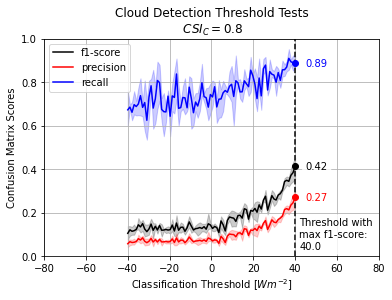

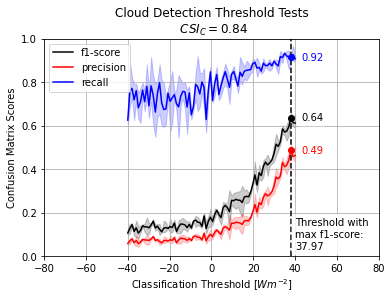

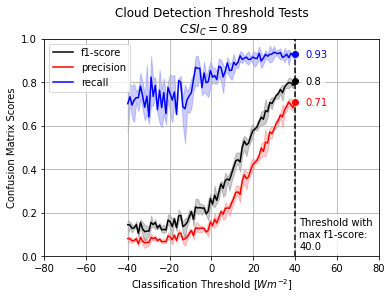

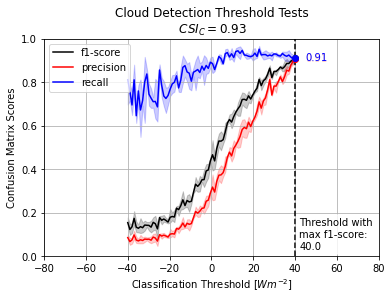

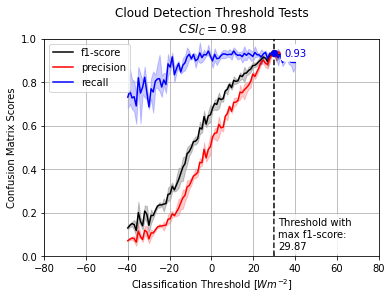

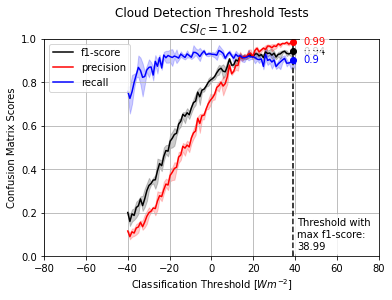

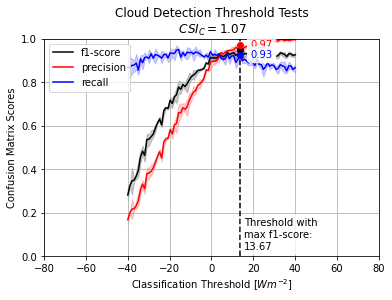

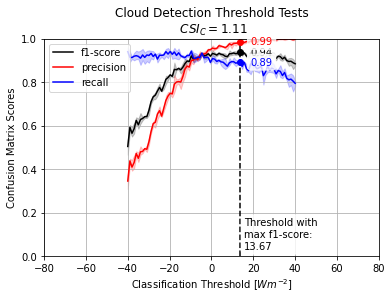

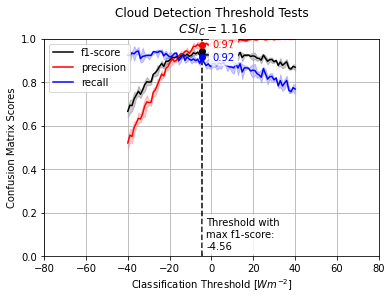

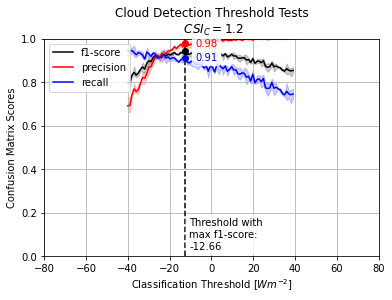

In [14]:
for csi_threshold_i in df.csi_threshold.unique():
    df_i = df.loc[df.csi_threshold == csi_threshold_i]
    
    fig, ax = plt.subplots(figsize=(6,4))
    plt.grid(True)
    
    # Plot f1-score, precision, recall versus the threshold I choose
    # f1-scores
    ax.plot(df_i.lw_threshold.groupby(df_i.lw_threshold).mean(), df_i.f1_score.groupby(df_i.lw_threshold).mean(),'-k',alpha=1)
    ax.fill_between(df_i.lw_threshold.groupby(df_i.lw_threshold).mean(),
                     df_i.f1_score.groupby(df_i.lw_threshold).min(),
                     df_i.f1_score.groupby(df_i.lw_threshold).max(),color='k',alpha=0.2)
    # precision
    ax.plot(df_i.lw_threshold.groupby(df_i.lw_threshold).mean(), df_i.precision.groupby(df_i.lw_threshold).mean(),'-r',alpha=1)
    ax.fill_between(df_i.lw_threshold.groupby(df_i.lw_threshold).mean(),
                     df_i.precision.groupby(df_i.lw_threshold).min(),
                     df_i.precision.groupby(df_i.lw_threshold).max(),color='r',alpha=0.2)
    # recall
    ax.plot(df_i.lw_threshold.groupby(df_i.lw_threshold).mean(), df_i.recall.groupby(df_i.lw_threshold).mean(),'-b',alpha=1)
    ax.fill_between(df_i.lw_threshold.groupby(df_i.lw_threshold).mean(),
                     df_i.recall.groupby(df_i.lw_threshold).min(),
                     df_i.recall.groupby(df_i.lw_threshold).max(),color='b',alpha=0.2)
    
    # Find the highest f1-score
    df_means = df_i.groupby(df.lw_threshold).mean()
    best_f1_score = df_means.f1_score.max()
    best_threshold = df_means.loc[df_means.f1_score == best_f1_score].index.values[0]
    best_precision = df_means.loc[df_means.f1_score == best_f1_score].precision.values[0]
    best_recall = df_means.loc[df_means.f1_score == best_f1_score].recall.values[0]
    
    # Plot the threshold cooresponding to the best f1-score:
    ax.axvline(best_threshold,color='k', linestyle='--')
    plt.text(best_threshold+2,0.1, 'Threshold with\nmax f1-score:\n' + str(np.round(best_threshold,2)), size=10, rotation=0,
             ha="left", va="center", color='k',
             bbox=dict(boxstyle="round",
                       ec='white',
                       fc='white',
                       alpha=0.8
                       )
             )
    
    # Plot the best f1-score:
    ax.plot(best_threshold,best_f1_score,'ok')
    plt.text(best_threshold+5,best_f1_score, str(np.round(best_f1_score,2)), size=10, rotation=0,
             ha="left", va="center", color='k',
             bbox=dict(boxstyle="round",
                       ec='white',
                       fc='white',
                       alpha=0.8
                       )
             )

    # Plot the precision cooresponding to the best f1-score:
    ax.plot(best_threshold,best_precision,'or')
    plt.text(best_threshold+5,best_precision, str(np.round(best_precision,2)), size=10, rotation=0,
             ha="left", va="center", color='r',
             bbox=dict(boxstyle="round",
                       ec='white',
                       fc='white',
                       alpha=0.8
                       )
             )
    
    # Plot the recall cooresponding to the best f1-score:
    ax.plot(best_threshold,best_recall,'ob')
    plt.text(best_threshold+5,best_recall, str(np.round(best_recall,2)), size=10, rotation=0,
             ha="left", va="center", color='b',
             bbox=dict(boxstyle="round",
                       ec='white',
                       fc='white',
                       alpha=0.8
                       )
             )
    
    
    # make legend
    lines = [ax.lines[0], ax.lines[1], ax.lines[2]]
    labels = ['f1-score', 'precision', 'recall']
    ax.legend(lines, labels, loc='upper left', ncol=1)
    ax.set_xlim([-80,80])
    ax.set_ylim([0,1])
    ax.set_xlabel('Classification Threshold [$Wm^{-2}$]')
    ax.set_ylabel('Confusion Matrix Scores')
    ax.set_title('Cloud Detection Threshold Tests\n $CSI_C = ${}'.format(np.round(1 + csi_threshold_i,2)));



Group by unique pairs of lw_threshold and csi_threshold values, then take the mean of the confusion matrix scores and find the max f1_score.

In [15]:
top_scores = df.groupby(['lw_threshold', 'csi_threshold'], as_index=False).mean().sort_values(by=['f1_score'], ascending=False)
top_scores.head()

,lw_threshold,csi_threshold,f1_score,precision,recall
536,13.670886,0.066667,0.949098,0.972752,0.926588
279,-12.658228,0.200000,0.944765,0.978906,0.913040
785,38.987342,0.022222,0.943546,0.986848,0.904172
358,-4.556962,0.155556,0.942802,0.972294,0.915236
745,34.936709,0.022222,0.942491,0.977749,0.909764


Based on this parameter test, I'm going to use a lw_threshold = $13.67\approx14\,Wm^{-2}$, and csi_threshold = $1+0.0667 \approx 1$ 

***
***